In [21]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, transforms
import pytorch_lightning as pl
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import glob, itertools

In [22]:
config = {
    "dataset_path" : "/kaggle/working/cat_dataset",
    "batch_size" : 150,
    "num_workers":4,
    "dataset_path" : "../input/edges2shoes-dataset",
    "debug_mode" : True
}

In [23]:
# from matplotlib import pyplot as plt
# import numpy as np

In [24]:
# for item in loader:
#     real,sketch = item
#     print(sketch[1].shape)
#     image_to_plot = np.transpose(real[3], (1, 2, 0))
#     plt.imshow(image_to_plot)
#     break

In [25]:
# for i in dataset:
#     print(i[0].shape)
#     p
#     break

In [26]:
# dataset

In [27]:
# Define the transformations for input and target images
# input_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))  # Normalize the input sketch images
# ])
input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the input sketch images
])
target_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the target images
])

In [28]:
from torch.utils.data import Dataset

class SketchDataset(Dataset):
    def __init__(self, root, input_transform=None,mode='train'):
#         self.sketch_paths = sketch_paths
#         self.image_paths = image_paths
        self.files = sorted(glob.glob(os.path.join(root, mode) + "/*.*"))
        self.transform = input_transform
#         self.target_transform = target_transform
        if config["debug_mode"]:
            self.files = self.files[:100]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
#         sketch_path = self.sketch_paths[idx]
#         image_path = self.image_paths[idx]
        img = Image.open(self.files[idx % len(self.files)])
        w, h = img.size
        img_A = img.crop((0, 0, w / 2, h))
        img_B = img.crop((w / 2, 0, w, h))

        if np.random.random() < 0.5:
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], "RGB")
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], "RGB")

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

#         sketch = Image.open(sketch_path).convert('RGB')  # Load the sketch image and convert to grayscale
#         image = Image.open(image_path).convert("RGB")  # Load the target image as RGB
#         plt.imshow(sketch)
#         plt.show()
#         plt.imshow(image)
#         plt.show()
        
#         print(sketch.mode,image.mode)

#         if self.input_transform:
#             sketch = self.input_transform(sketch)

#         if self.target_transform:
#             image = self.target_transform(image)

        return img_A, img_B

In [29]:
class UpSampleConv(nn.Module):

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel=4,
        strides=2,
        padding=1,
        activation=True,
        batchnorm=True,
        dropout=False
    ):
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm
        self.dropout = dropout

        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.ReLU(True)

        if dropout:
            self.drop = nn.Dropout2d(0.5)

    def forward(self, x):
        x = self.deconv(x)
        if self.batchnorm:
            x = self.bn(x)

        if self.dropout:
            x = self.drop(x)
        return x

In [30]:
class DownSampleConv(nn.Module):

    def __init__(self, in_channels, out_channels, kernel=4, strides=2, padding=1, activation=True, batchnorm=True):
        """
        Paper details:
        - C64-C128-C256-C512-C512-C512-C512-C512
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        """
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm

        self.conv = nn.Conv2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.bn(x)
        if self.activation:
            x = self.act(x)
        return x

In [31]:
class Generator(nn.Module):

    def __init__(self, in_channels, out_channels):
        """
        Paper details:
        - Encoder: C64-C128-C256-C512-C512-C512-C512-C512
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        - Decoder: CD512-CD1024-CD1024-C1024-C1024-C512 -C256-C128
        """
        super().__init__()

        # encoder/donwsample convs
        self.encoders = [
            DownSampleConv(in_channels, 64, batchnorm=False),  # bs x 64 x 128 x 128
            DownSampleConv(64, 128),  # bs x 128 x 64 x 64
            DownSampleConv(128, 256),  # bs x 256 x 32 x 32
            DownSampleConv(256, 512),  # bs x 512 x 16 x 16
            DownSampleConv(512, 512),  # bs x 512 x 8 x 8
            DownSampleConv(512, 512),  # bs x 512 x 4 x 4
            DownSampleConv(512, 512),  # bs x 512 x 2 x 2
            DownSampleConv(512, 512, batchnorm=False),  # bs x 512 x 1 x 1
        ]

        # decoder/upsample convs
        self.decoders = [
            UpSampleConv(512, 512, dropout=True),  # bs x 512 x 2 x 2
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 4 x 4
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 8 x 8
            UpSampleConv(1024, 512),  # bs x 512 x 16 x 16
            UpSampleConv(1024, 256),  # bs x 256 x 32 x 32
            UpSampleConv(512, 128),  # bs x 128 x 64 x 64
            UpSampleConv(256, 64),  # bs x 64 x 128 x 128
        ]
        self.decoder_channels = [512, 512, 512, 512, 256, 128, 64]
        self.final_conv = nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

        self.encoders = nn.ModuleList(self.encoders)
        self.decoders = nn.ModuleList(self.decoders)

    def forward(self, x):
        skips_cons = []
        for encoder in self.encoders:
            x = encoder(x)

            skips_cons.append(x)

        skips_cons = list(reversed(skips_cons[:-1]))
        decoders = self.decoders[:-1]

        for decoder, skip in zip(decoders, skips_cons):
            x = decoder(x)
            # print(x.shape, skip.shape)
            x = torch.cat((x, skip), axis=1)

        x = self.decoders[-1](x)
        # print(x.shape)
        x = self.final_conv(x)
        return self.tanh(x)

In [32]:
class PatchGAN(nn.Module):

    def __init__(self, input_channels):
        super().__init__()
        self.d1 = DownSampleConv(input_channels, 64, batchnorm=False)
        self.d2 = DownSampleConv(64, 128)
        self.d3 = DownSampleConv(128, 256)
        self.d4 = DownSampleConv(256, 512)
        self.final = nn.Conv2d(512, 1, kernel_size=1)

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.d1(x)
        x1 = self.d2(x0)
        x2 = self.d3(x1)
        x3 = self.d4(x2)
        xn = self.final(x3)
        return xn

In [33]:
adversarial_loss = nn.BCEWithLogitsLoss()

reconstruction_loss = nn.L1Loss()

In [34]:
def _weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
def display_progress(cond, fake, real, figsize=(10,5)):
    cond = cond.detach().cpu().permute(1, 2, 0)
    fake = fake.detach().cpu().permute(1, 2, 0)
    real = real.detach().cpu().permute(1, 2, 0)
    
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    ax[0].imshow(cond)
    ax[1].imshow(real)
    ax[2].imshow(fake)
    plt.show()

In [35]:
class Pix2Pix(pl.LightningModule):

    def __init__(self, in_channels, out_channels, learning_rate=0.0002, lambda_recon=200, display_step=1):

        super().__init__()
        self.save_hyperparameters()
        
        self.display_step = display_step
        self.gen = Generator(in_channels, out_channels)
        self.patch_gan = PatchGAN(in_channels + out_channels)

        # intializing weights
        self.gen = self.gen.apply(_weights_init)
        self.patch_gan = self.patch_gan.apply(_weights_init)

        self.adversarial_criterion = nn.BCEWithLogitsLoss()
        self.recon_criterion = nn.L1Loss()
        self.automatic_optimization = False
        self.hparams.learning_rate = learning_rate
        self.hparams.lambda_recon = lambda_recon

    def _gen_step(self, real_images, conditioned_images):
        # Pix2Pix has adversarial and a reconstruction loss
        # First calculate the adversarial loss
        fake_images = self.gen(conditioned_images)
        disc_logits = self.patch_gan(fake_images, conditioned_images)
        adversarial_loss = self.adversarial_criterion(disc_logits, torch.ones_like(disc_logits))

        # calculate reconstruction loss
        recon_loss = self.recon_criterion(fake_images, real_images)
        lambda_recon = self.hparams.lambda_recon

        return adversarial_loss + lambda_recon * recon_loss

    def _disc_step(self, real_images, conditioned_images):
        fake_images = self.gen(conditioned_images).detach()
        fake_logits = self.patch_gan(fake_images, conditioned_images)

        real_logits = self.patch_gan(real_images, conditioned_images)

        fake_loss = self.adversarial_criterion(fake_logits, torch.zeros_like(fake_logits))
        real_loss = self.adversarial_criterion(real_logits, torch.ones_like(real_logits))
        return (real_loss + fake_loss) / 2

    def configure_optimizers(self):
        lr = self.hparams.learning_rate
        gen_opt = torch.optim.Adam(self.gen.parameters(), lr=lr)
        disc_opt = torch.optim.Adam(self.patch_gan.parameters(), lr=lr)
        return disc_opt, gen_opt
    
    def forward(self, conditioned_images):
        # Forward pass through the generator
        generated_images = self.gen(conditioned_images)
        return generated_images

#     def training_step(self, batch, batch_idx, optimizer_idx):
#         real, condition = batch

#         loss = None
#         if optimizer_idx == 0:
#             loss = self._disc_step(real, condition)
#             self.log('PatchGAN Loss', loss)
#         elif optimizer_idx == 1:
#             loss = self._gen_step(real, condition)
#             self.log('Generator Loss', loss)
        
#         if self.current_epoch%self.display_step==0 and batch_idx==0 and optimizer_idx==1:
#             fake = self.gen(condition).detach()
#             display_progress(condition[0], fake[0], real[0])
#         return loss

    def training_step(self, batch, batch_idx):
            condition,real = batch
            opt_disc, opt_gen = self.optimizers()

            # Discriminator update
            opt_disc.zero_grad()
            disc_loss = self._disc_step(real, condition)
            self.log('PatchGAN Loss', disc_loss)
            self.manual_backward(disc_loss)
            opt_disc.step()

            # Generator update
            opt_gen.zero_grad()
            gen_loss = self._gen_step(real, condition)
            self.log('Generator Loss', gen_loss)
            self.manual_backward(gen_loss)
            opt_gen.step()

            if self.current_epoch % self.display_step == 0 and batch_idx == 0:
                fake = self.gen(condition).detach()
                display_progress(condition[0], fake[0], real[0])
#             print("Epoch: ",self.current_epoch,)

            return gen_loss

In [36]:
dataset = SketchDataset(config['dataset_path'],input_transform)        
dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True, num_workers=config["num_workers"])

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

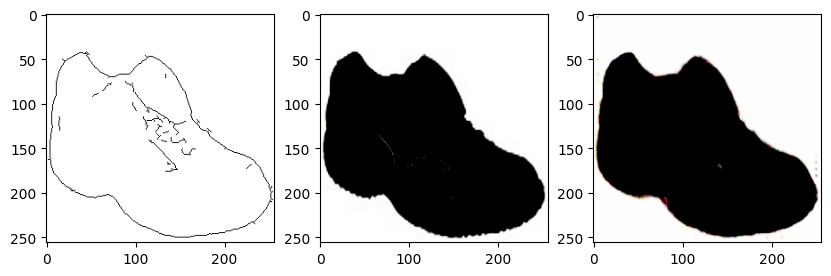

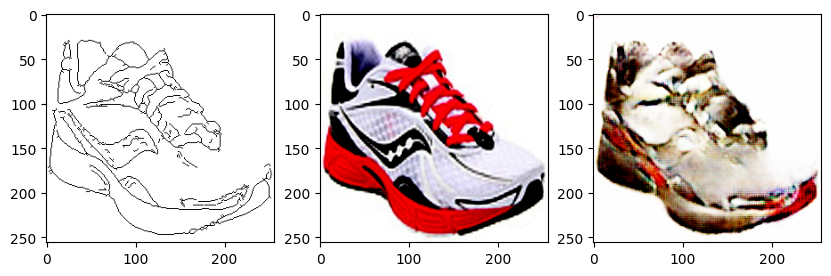

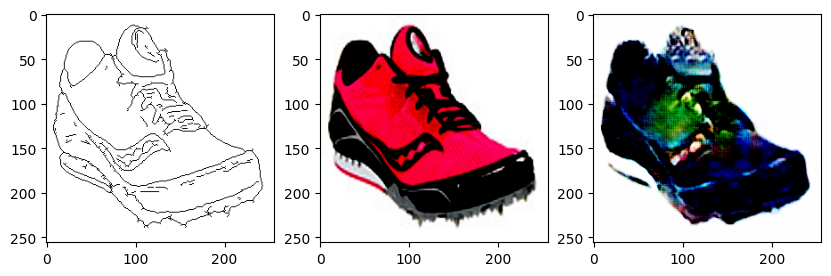

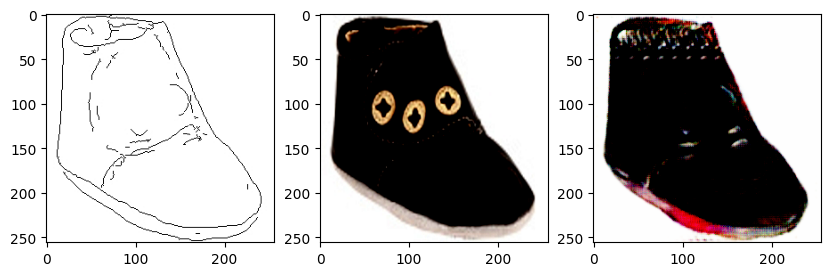

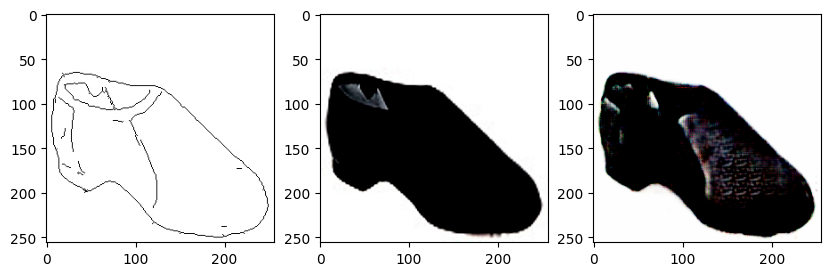

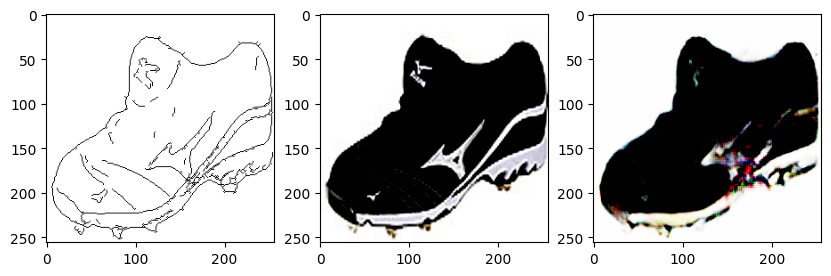

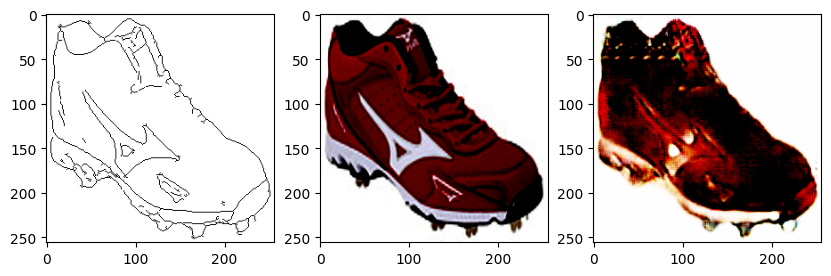

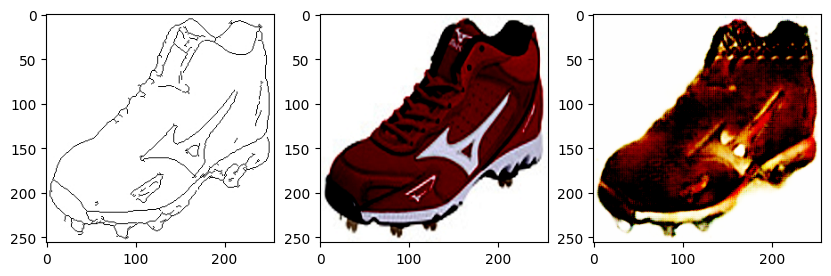

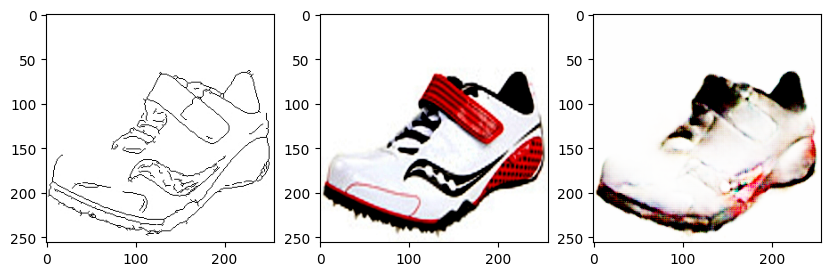

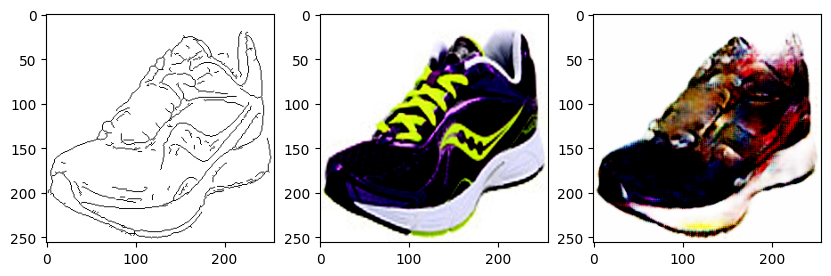

In [37]:
model = Pix2Pix(3, 3)
model.load_state_dict(torch.load("/kaggle/input/edges-2-shoes/pytorch/version2/1/model7.ckpt")['state_dict'])
trainer = pl.Trainer(max_epochs=10,callbacks=[
        pl.callbacks.ModelCheckpoint(
            monitor='Generator Loss',  # Monitor the Generator Loss for saving checkpoints
            dirpath='./',
            save_top_k=3,  # Save the top 3 checkpoints based on Generator Loss
            mode='min',  # Minimize the Generator Loss
            every_n_epochs=1,  # Save a checkpoint after every epoch
        )
    ])
trainer.fit(model, dataloader)

In [38]:
save_path = "model.ckpt"
trainer.save_checkpoint(save_path)

In [39]:
# model = Pix2Pix(3,3)
# model.load_state_dict(torch.load("model.ckpt"))

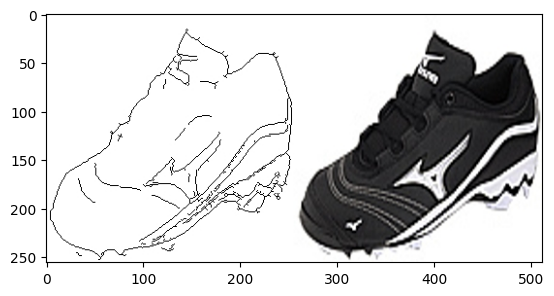

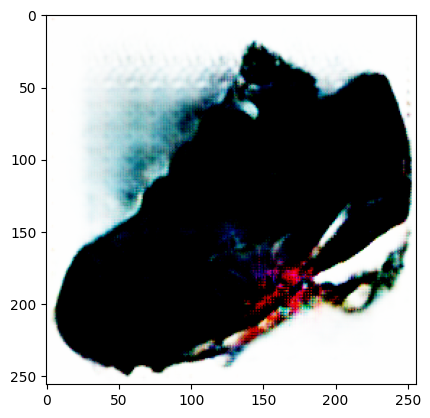

In [40]:
model.eval()
image = Image.open("/kaggle/input/edges2shoes-dataset/train/10037_AB.jpg")
plt.imshow(image)
plt.show()
w, h = image.size
image = image.crop((0, 0, w / 2, h))
image = input_transform(image)
image = image.unsqueeze(0)
with torch.no_grad():
    output = model(image)
# output.shape
arr = np.transpose(output[0],(1,2,0))
plt.imshow(arr)

In [41]:
# plt.imshow(image)

In [42]:
# # Define the Pix2Pix GAN model
# class Pix2PixGAN(pl.LightningModule):
#     def __init__(self, generator, discriminator, lr=0.0002, b1=0.5, b2=0.999):
#         super(Pix2PixGAN, self).__init__()
#         self.generator = generator
#         self.discriminator = discriminator
#         self.lr = lr
#         self.b1 = b1
#         self.b2 = b2
#         self.criterion_gan = nn.BCELoss()
#         self.criterion_pixelwise = nn.L1Loss()
#         self.automatic_optimization = False

#     def training_step(self, batch, batch_idx):
#         sketches, real_images = batch
#         batch_size = real_images.size(0)
#         valid = torch.ones(batch_size, *self.discriminator.output_shape, device=self.device)
#         fake = torch.zeros(batch_size, *self.discriminator.output_shape, device=self.device)
        
#         optimizer_g, optimizer_d = self.optimizers()
#         gen_images = self.generator(sketches)
#         gen_loss_gan = self.criterion_gan(self.discriminator(gen_images, sketches), valid)
#         gen_loss_pixelwise = self.criterion_pixelwise(gen_images, real_images)
#         gen_loss = gen_loss_gan + 100 * gen_loss_pixelwise

#         optimizer_g.zero_grad()  # Reset gradients
#         gen_loss.backward(retain_graph=True)  # Backpropagation for generator
#         optimizer_g.step()  # Update generator parameters

#         # Discriminator update
#         real_pred = self.discriminator(real_images, sketches)
#         real_loss = self.criterion_gan(real_pred, valid)
#         gen_images = self.generator(sketches).detach()  # Detach the generator output
#         fake_pred = self.discriminator(gen_images, sketches)
#         fake_loss = self.criterion_gan(fake_pred, fake)
#         disc_loss = (real_loss + fake_loss) / 2

#         optimizer_d.zero_grad()  # Reset gradients
#         disc_loss.backward()  # Backpropagation for discriminator
#         optimizer_d.step()  # Update discriminator parameters

#         tqdm_dict = {'gen_loss_gan': gen_loss_gan, 'gen_loss_pixelwise': gen_loss_pixelwise,
#                      'real_loss': real_loss, 'fake_loss': fake_loss}
#         output = {
#             'loss': disc_loss + gen_loss,
#             'progress_bar': tqdm_dict,
#             'log': tqdm_dict
#         }
#         return output

#     def configure_optimizers(self):
#         optimizer_g = optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.b1, self.b2))
#         optimizer_d = optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.b1, self.b2))
#         return [optimizer_g, optimizer_d], []

#     def train_dataloader(self):
#         # Define your dataset and transformations
# #         dataset = ImageFolder(config["dataset_path"], transform=Compose([Resize((256, 256)), ToTensor()]))
#         dataset = SketchDataset(sketch_path, image_path, input_transform, target_transform)        
#         return DataLoader(dataset, batch_size=config['batch_size'], shuffle=True, num_workers=config["num_workers"])



In [43]:
# import torch
# import torch.nn as nn

# # Define the Generator
# class Generator(nn.Module):
#     def __init__(self, in_channels=3, out_channels=3, ngf=64):
#         super(Generator, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(in_channels, ngf, kernel_size=4, stride=2, padding=1),
#             nn.LeakyReLU(0.2),
#             nn.Conv2d(ngf, ngf * 2, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(ngf * 2),
#             nn.LeakyReLU(0.2),
#             nn.Conv2d(ngf * 2, ngf * 4, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(ngf * 4),
#             nn.LeakyReLU(0.2),
#         )

#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(),
#             nn.ConvTranspose2d(ngf, out_channels, kernel_size=4, stride=2, padding=1),
#             nn.Tanh(),
#         )

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

# # Define the Discriminator
# class Discriminator(nn.Module):
#     def __init__(self, in_channels=6, ndf=64):
#         super(Discriminator, self).__init__()
#         self.main = nn.Sequential(
#             nn.Conv2d(in_channels, ndf, kernel_size=4, stride=2, padding=1),
#             nn.LeakyReLU(0.2),
#             nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(ndf * 2),
#             nn.LeakyReLU(0.2),
#             nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2),
#             nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(ndf * 8),
#             nn.LeakyReLU(0.2),
#             nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0),
#             nn.Sigmoid(),
#         )

#     def forward(self, x, y):
#         x = torch.cat((x, y), dim=1)
#         return self.main(x)

In [44]:
# generator = Generator()
# discriminator = Discriminator()
# model = Pix2PixGAN(generator, discriminator)

In [45]:
# # Train the model
# num_epochs = 10
# trainer = pl.Trainer(max_epochs=num_epochs)
# trainer.fit(model)